# Week 4: Introduction to CNNs in Keras

For comparison, we're going to use the same MNIST Handwritten Digit Dataset as last week, to see whether we can 
find a better model using a CNN. 

The first 6 models show how to create a simple CNN (the same basic design as was presented in the lesson, but
with realistic layer widths) and how to add various potential improvements. The last 5 models are examples
of deep CNNs for optimal performance. 

1. Simple CNN with 2 convolution layers and 2 dense layers
2. Simple CNN with ReduceLRonPlateau
3. Simple CNN with Exponential Decay
4. Simple CNN with Cosine Decay
5. Simple CNN plus Batch Norm and Dropout
6. Simple CNN plus L2 Normalization
7. VGG-16 with five pooling blocks and Global Average Pooling
8. VGG-16 with Flatten instead of GAP
9. VGG-16 with Dropout
10. Deep CNN with Batch Norm and Dropout
11. Deep CNN with Data Augmentation



## 1. Setup and Data Loading
Import necessary libraries and preprocess the MNIST dataset.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time


import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Flatten


# utility code

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


'''  How to time your code
# start timer
start = time.time()

<your code here> 

# Record end time and print execution time
end = time.time()
print(f"Execution Time: " + format_hms(end-start))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

notebook_start = time.time()

In [11]:
# Utility to print learning curves

results = {}

def plot_learning_curves(hist, 
                         title="Learning Curves", 
                         best_epoch=None,              # None = print absolute minimum val_loss point on both plots
                                                       # else assume is 0-based early stopping trigger point
                         verbose=True
                        ):

    val_losses = hist.history['val_loss']
    
    if best_epoch:
        min_val_epoch = best_epoch
    else:
        min_val_epoch = val_losses.index(min(val_losses))
        
    val_loss_at_min_loss = hist.history['val_loss'][min_val_epoch]    
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]
    

    n_epochs = len(val_losses)
    epochs = list(range(1, n_epochs + 1))

    # Determine tick interval and xticks starting from 0

    tick_interval = max(1, n_epochs // 20)
    xticks = list(range(0, n_epochs + 1, tick_interval))

    plt.figure(figsize=(8, 8))

    # --- Loss Plot ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist.history['loss'], label='Train Loss')
    plt.plot(epochs, hist.history['val_loss'], label='Val Loss')
    plt.scatter(min_val_epoch + 1, val_loss_at_min_loss, color='red', marker='x', s=50, label='Min Val Loss') 
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, hist.history['val_accuracy'], label='Val Accuracy')
    plt.scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='Acc @ Min Val Loss')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1.05)
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {val_loss_at_min_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss, min_val_epoch + 1)

#### The MNIST Dataset  

Let's load the dataset just as we did last time. 

In [12]:
# Load and preprocess MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1,28,28,1).astype('float32')/255.0
X_test = X_test.reshape(-1,28,28,1).astype('float32')/255.0
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_test,y_test` already defined, accessed here as global variables

In [13]:
# Globals

global_epochs = 200
global_batch_size = 256
global_learning_rate = 0.0001

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / global_batch_size))
total_steps = global_epochs * steps_per_epoch

# Store results of runs by title


In [14]:
def train_and_test(model, 
                   epochs        = global_epochs,                 # Just needs to be bigger than early stop point
                   lr_schedule   = global_learning_rate,                 # Default for Adam / 10. Seems to work well in general on this task. 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = global_batch_size, 
                   use_early_stopping = True,
                   patience      = 10,                     # To turn off early stopping, set patience to same as epochs
                   min_delta     = 0.001,                 # We only look at first 4 digits after decimal point
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"{title}:  ",end='')
    # If parameters are not at defaults given above, print them out

    if lr_schedule != global_learning_rate:
        print(f'lr_schedule: {lr_schedule}', end='')
    if batch_size != global_batch_size:
        print(f'\tbatch_size: {batch_size}', end='')
    if patience != 10:
        print(f'\tpatience: {patience}', end='')
    if min_delta != 0.001:
        print(f'\tmin_delta: {min_delta}', end='')
    if callbacks != []:
        print(f'\tcallbacks: {callbacks}', end='')
    print('\n')

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=global_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=cbs,
                        verbose=verbose
                       )

    best_epoch = early_stop.best_epoch
    best_acc    = history.history['val_accuracy'][best_epoch]

    
    # Plot training history
    plot_learning_curves(history, title=title, best_epoch = best_epoch)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=verbose)
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

#### Callbacks (inputs to fit)

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

#### Learning Rate Schedulers (input to optimizer Adam)

In [16]:
exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### 1. Simple CNN model

We start with the simplest CNN model, based on the "expanding CNN layer" strategy (32 -> 64). 


In [17]:
tiny_cnn = models.Sequential(
    [
        Input((28,28,3)),  
        Conv2D(3, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(4, (3, 3), activation='relu'),              
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ],
    name = "Tiny_CNN"
)

tiny_cnn.summary()

Model: "Tiny_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982 (7.74 KB)

 Trainable params: 1,982 (7.74 KB)

 Non-trainable params: 0 (0.00 B)

Simple CNN:  



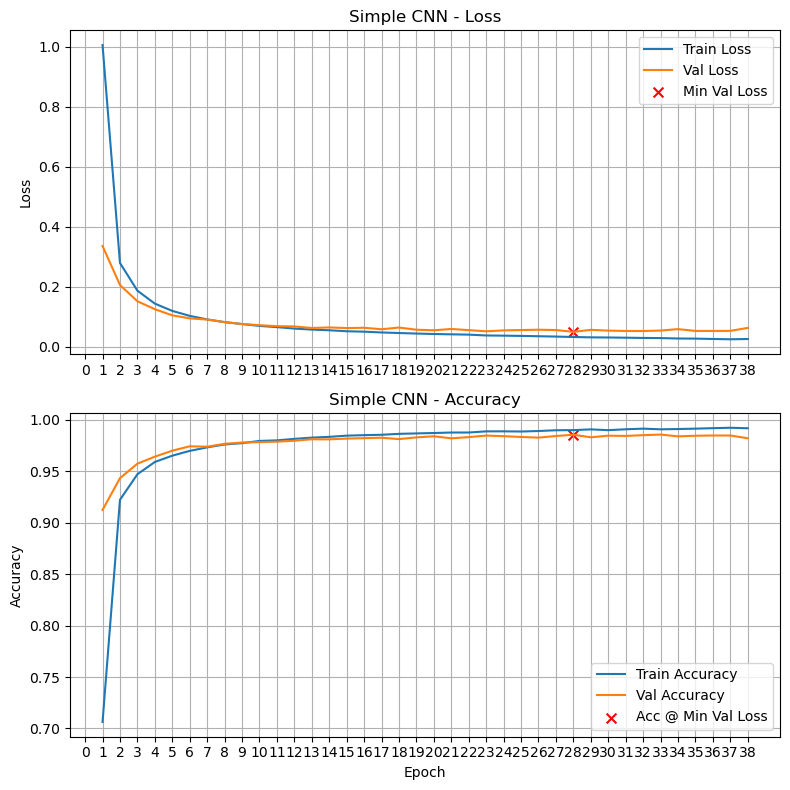

Final Training Loss:            0.0262
Final Training Accuracy:        0.9920
Final Validation Loss:          0.0632
Final Validation Accuracy:      0.9822
Minimum Validation Loss:        0.0500 (Epoch 28)
Validation Accuracy @ Min Loss: 0.9857

Test Accuracy: 0.9860
Test Loss: 0.0423

Validation-Test Gap (accuracy): 0.000333

Execution Time: 00:02:16


In [19]:
model_simple1 = models.Sequential([
    Input(shape=X_train.shape[1:]),  
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),              
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax')  # 10 output classes for digits 0-9
])


train_and_test(model_simple1,epochs=global_epochs,title="Simple CNN")

### 2. Simple CNN with ReduceLROnPlateau

### 2. Simple CNN with ReduceLROnPlateau

Top 5 Results of grid search:

    (0.987500011920929, 34) (0.3, 7, 0.001)
    (0.9871666431427002, 27) (0.3, 5, 1e-05)
    (0.9871666431427002, 35) (0.4, 7, 1e-05)
    (0.9869999885559082, 26) (0.4, 5, 1e-05)
    (0.9869999885559082, 27) (0.7, 5, 0.001)

Simple CNN + ReduceLROnPlateau:  	callbacks: [<keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x427f33430>]



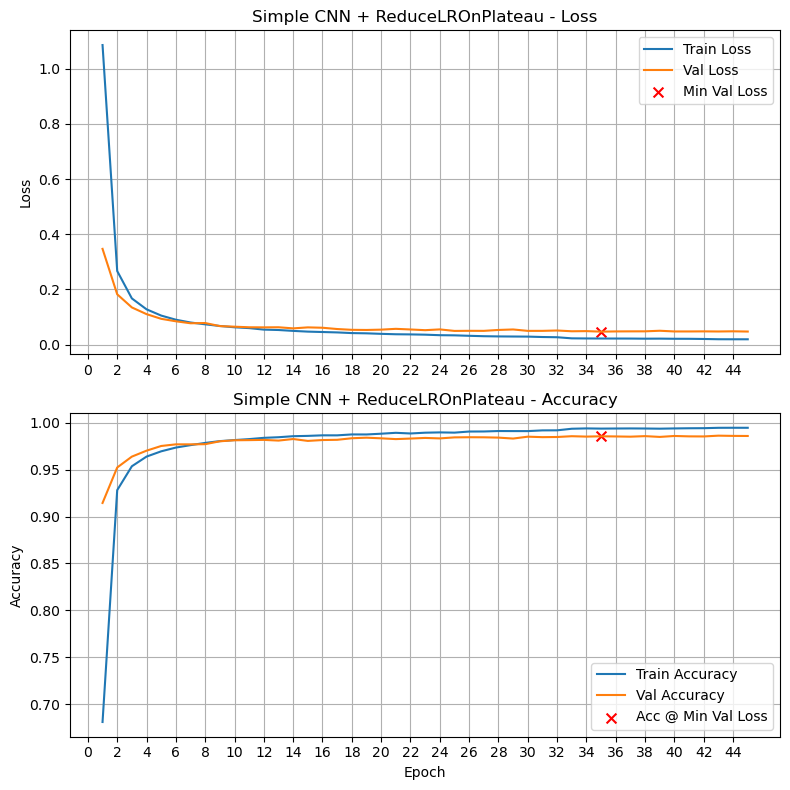

Final Training Loss:            0.0193
Final Training Accuracy:        0.9946
Final Validation Loss:          0.0474
Final Validation Accuracy:      0.9858
Minimum Validation Loss:        0.0471 (Epoch 35)
Validation Accuracy @ Min Loss: 0.9855

Test Accuracy: 0.9881
Test Loss: 0.0392

Validation-Test Gap (accuracy): 0.002600

Execution Time: 00:02:41


In [20]:
model_simple2 = models.Sequential([
    Input(shape=X_train.shape[1:]),  
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),              # The "expanding CNN layer" (32 -> 64) design is common
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax')  # 10 output classes for digits 0-9
])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=7,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=0.001,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)


train_and_test(model_simple2,epochs=global_epochs,title="Simple CNN + ReduceLROnPlateau",callbacks=[reduce_lr])

### 3. Simple CNN with Exponential Decay

Top 5 results of grid search for initial_learning_rate, epochs, decay_rate:

    (0.9863333106040955, 24) (0.0001, 120, 0.95)
    (0.9862499833106995, 22) (0.0001, 30, 0.95)
    (0.9859166741371155, 20) (0.0001, 70, 0.95)
    (0.9859166741371155, 108) (1e-05, 120, 0.95)
    (0.9857500195503235, 5) (0.001, 120, 0.95)


Simple CNN + Exponential Decay:  lr_schedule: <keras.src.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x42c7f5030>



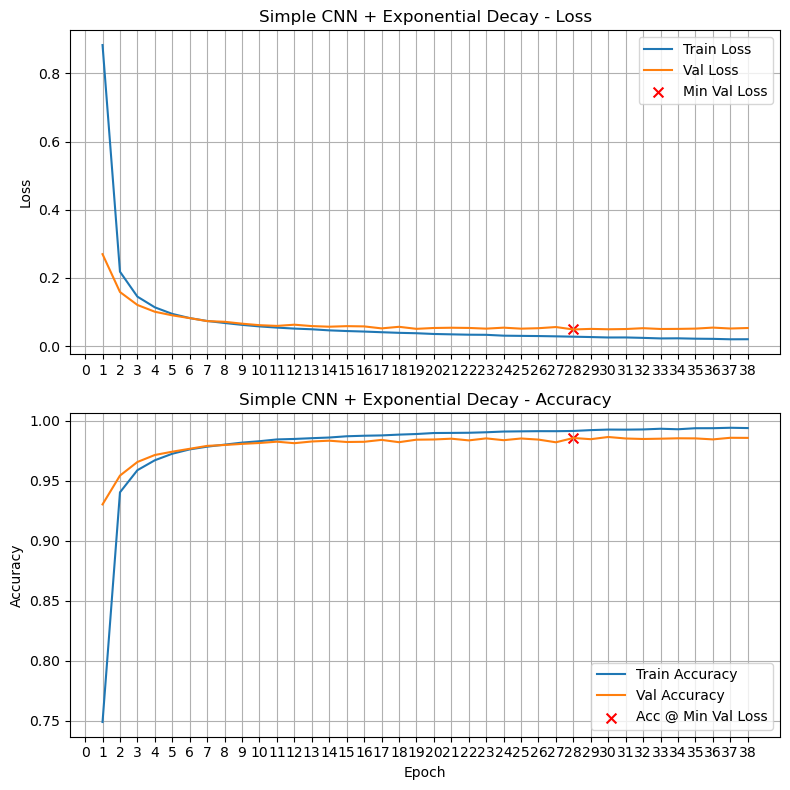

Final Training Loss:            0.0199
Final Training Accuracy:        0.9939
Final Validation Loss:          0.0528
Final Validation Accuracy:      0.9858
Minimum Validation Loss:        0.0486 (Epoch 28)
Validation Accuracy @ Min Loss: 0.9857

Test Accuracy: 0.9857
Test Loss: 0.0427

Validation-Test Gap (accuracy): 0.000033

Execution Time: 00:02:02


In [21]:
model_simple3 = models.Sequential([
    Input(shape=X_train.shape[1:]),  
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),              # The "expanding CNN layer" (32 -> 64) design is common
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax')  # 10 output classes for digits 0-9
])


temp_epochs = 120
temp_total_steps = temp_epochs * steps_per_epoch


exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001, # ─ the starting learning rate (before any decay)
    decay_steps=temp_total_steps,       # ─ how many training steps (batches) before applying decay
    decay_rate=.95,                # ─ multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,               # ─ if True, decay in discrete intervals (floor(step/decay_steps)),
                                   #   if False, decay smoothly each step
)


train_and_test(model_simple3,epochs=temp_epochs,lr_schedule=exp_decay,title="Simple CNN + Exponential Decay")

### 4. Simple CNN with Cosine Decay



Simple CNN + Cosine Decay:  lr_schedule: <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x403e86770>



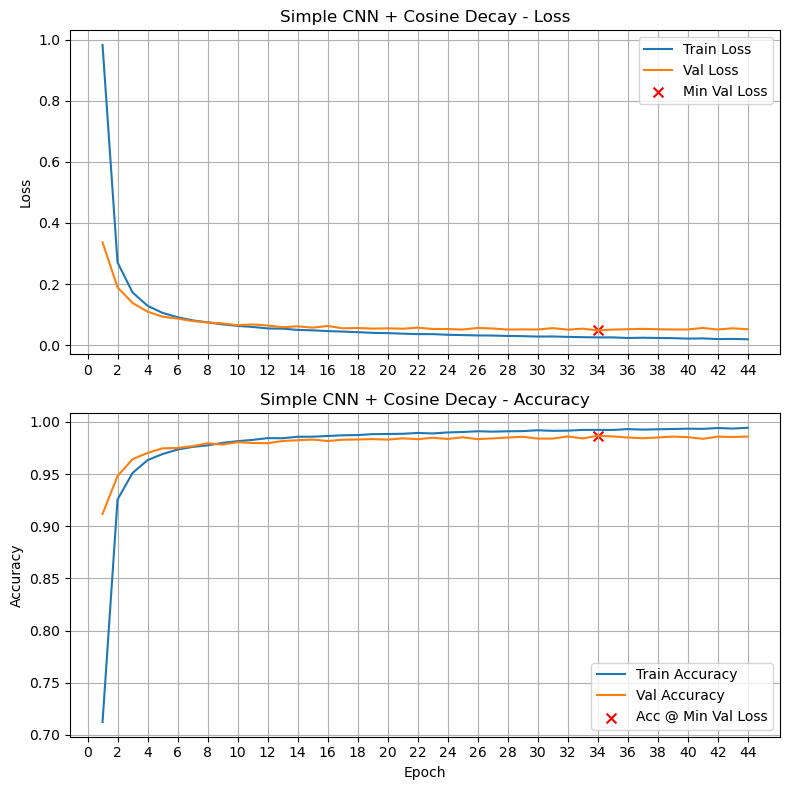

Final Training Loss:            0.0192
Final Training Accuracy:        0.9944
Final Validation Loss:          0.0521
Final Validation Accuracy:      0.9859
Minimum Validation Loss:        0.0484 (Epoch 34)
Validation Accuracy @ Min Loss: 0.9867

Test Accuracy: 0.9880
Test Loss: 0.0393

Validation-Test Gap (accuracy): 0.001333

Execution Time: 00:02:32


In [22]:
model_simple4 = models.Sequential([
    Input(shape=X_train.shape[1:]),  
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),              # The "expanding CNN layer" (32 -> 64) design is common
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax')  # 10 output classes for digits 0-9
])


epochs          = 20
initial_lr      = 1e-2          # MNIST converges faster with 0.005–0.02

steps_per_epoch = len(X_train) // global_batch_size
total_steps     = epochs * steps_per_epoch

cosine_lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_lr,
    decay_steps           = total_steps,
    alpha                 = 0.1,          # keep 10 % of the start LR
    warmup_steps=5 * steps_per_epoch,   # 5 warm‑up epochs
    warmup_target=initial_lr/2
)


train_and_test(model_simple4,epochs=epochs,lr_schedule=cosine_decay,title="Simple CNN + Cosine Decay")

### 5. Simple CNN plus Batch Normalization and Dropout in the dense layer

Results for different dropout rates:

    (0.9904166460037231, 35) Simple CNN + Batch Norm and Dropout: 0.4
    (0.9903333187103271, 29) Simple CNN + Batch Norm and Dropout: 0.5
    (0.9898333549499512, 29) Simple CNN + Batch Norm and Dropout: 0.6
    (0.9891666769981384, 37) Simple CNN + Batch Norm and Dropout: 0.2
    (0.9891666769981384, 26) Simple CNN + Batch Norm and Dropout: 0.3
    (0.9890833497047424, 33) Simple CNN + Batch Norm and Dropout: 0.1

Notes:
- Since batch normalization shifts the activations, we'll do the activation function **after** batch normalization. This follows the usual pattern:

> Conv/Dense → BatchNorm → ReLU → (Dropout/Pooling)   
  
- Modest improvement with reduce on plateau and cosine decay.

Simple CNN + Batch Norm and Dropout:  



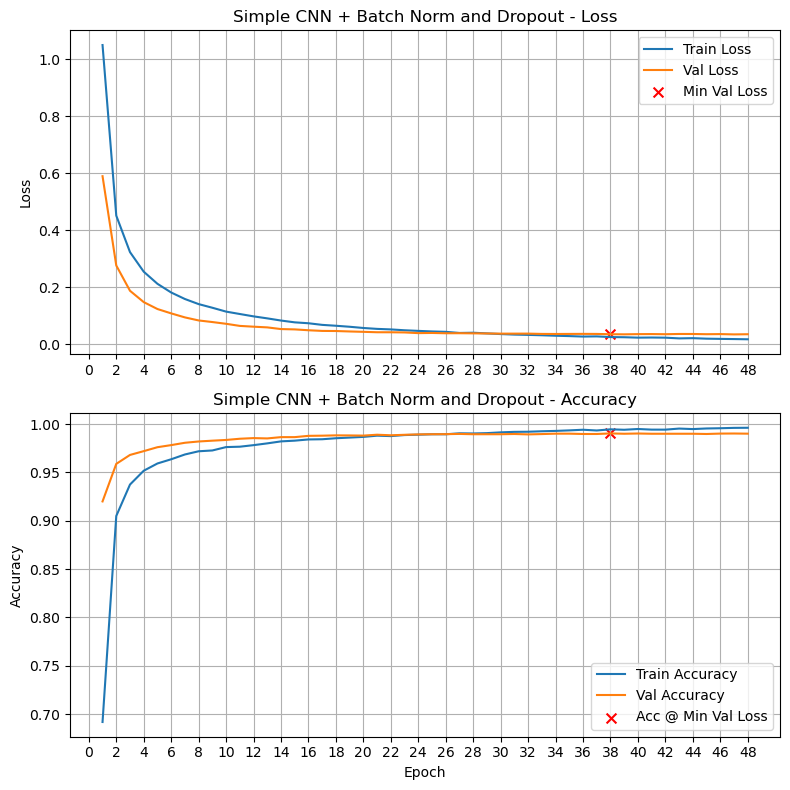

Final Training Loss:            0.0168
Final Training Accuracy:        0.9961
Final Validation Loss:          0.0345
Final Validation Accuracy:      0.9900
Minimum Validation Loss:        0.0345 (Epoch 38)
Validation Accuracy @ Min Loss: 0.9902

Test Accuracy: 0.9905
Test Loss: 0.0313

Validation-Test Gap (accuracy): 0.000250

Execution Time: 00:04:24


In [23]:

model_simple5 = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(10, activation='softmax')
])



train_and_test(model_simple5,title="Simple CNN + Batch Norm and Dropout")


### 6. Simple CNN plus L2 Normalization 

Top 5 results. All over the place!


    (0.9860000014305115, 45) Simple CNN + L2 Normalization: 0.001
    (0.9855833053588867, 26) Simple CNN + L2 Normalization: 1e-06
    (0.984000027179718, 17) Simple CNN + L2 Normalization: 0.0001
    (0.9817500114440918, 15) Simple CNN + L2 Normalization: 1e-05
    (0.971833348274231, 30) Simple CNN + L2 Normalization: 0.01
  

Simple CNN + L2 Normalization:  



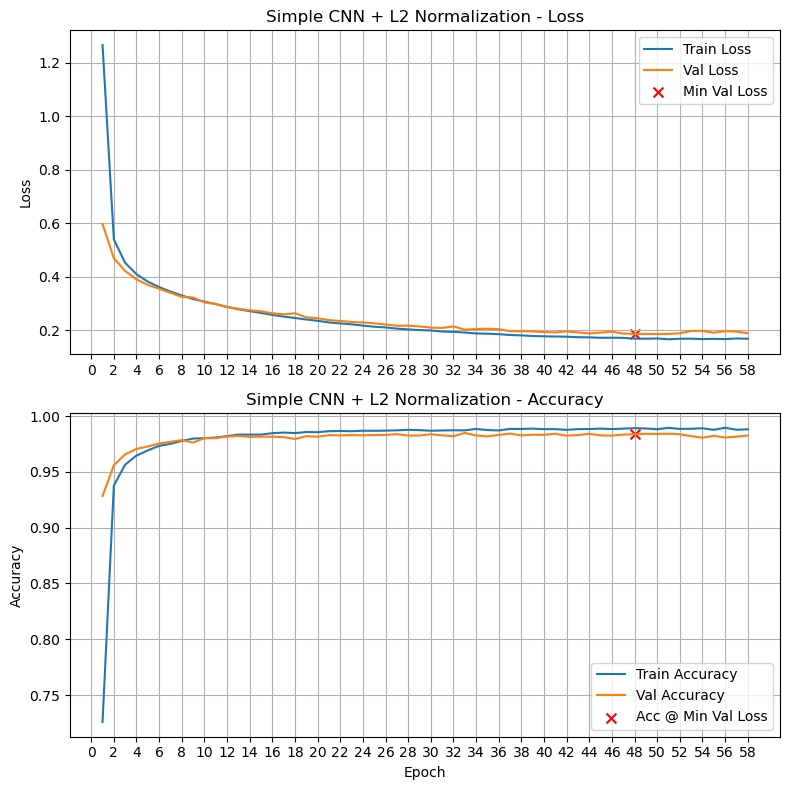

Final Training Loss:            0.1673
Final Training Accuracy:        0.9881
Final Validation Loss:          0.1878
Final Validation Accuracy:      0.9825
Minimum Validation Loss:        0.1853 (Epoch 48)
Validation Accuracy @ Min Loss: 0.9837

Test Accuracy: 0.9860
Test Loss: 0.1787

Validation-Test Gap (accuracy): 0.002250

Execution Time: 00:03:36


In [24]:

weight_decay = 0.001

model_simple6 = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3, 3), activation='relu',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(64, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(weight_decay)),

    Dense(10, activation='softmax')
])



train_and_test(model_simple6,epochs=global_epochs,title=f"Simple CNN + L2 Normalization")



### 7. VGG-16 

This well-known model uses four pooling blocks and a very large classification head. It also uses `GlobalAveragePooling`, which is characteristic of advanced CNNs designs. 

#### What does `GlobalAveragePooling2d()` do?

You will see either `layer.flatten()` or `layer.GlobalAveragePooling2D()` to make the transition between convolutional layers and the dense head. The latter possibility is
commonly used in CNNs and it is important to know why. 

**Flatten vs GlobalAveragePooling2D**

Both `Flatten()` and `GlobalAveragePooling2D()` are used to convert the 3D output of convolutional layers into a 1D vector that can be passed to a `Dense` layer — but they do it in very different ways:

- **`Flatten()`** unrolls all the pixels from all feature maps into a single long vector.  
  - Keeps all spatial detail  
  - Results in many more parameters when followed by a `Dense` layer  
  - **Example:** a `11×11×4` feature map becomes a 484-element vector

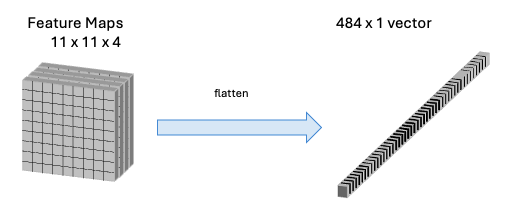

- **`GlobalAveragePooling2D()`** averages each feature map into a single number.  
  - Reduces spatial dimensions (H × W) by computing the mean of each feature map  
  - Produces far fewer parameters and encourages generalization  
  - **Example:** a `11x11x4` feature map becomes a 4-element vector:


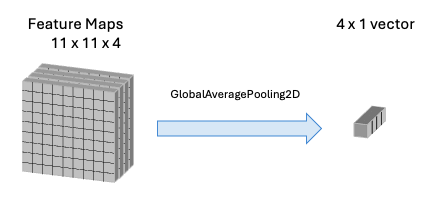

**Intuition**

*Use `Flatten()` when you want the dense layer to learn from every individual spatial location in every feature map.*  
*Use `GlobalAveragePooling2D()` when you only care about how strongly each feature is activated overall, not where it occurs.*

**In summary:**  
`Flatten()` retains all spatial information but can overfit due to high parameter count.  
`GlobalAveragePooling2D()` discards spatial layout but simplifies the model and often performs better in practice — especially in modern CNNs.

Notes:
- Got improvement with plateau and especially with cosine decay

VGG-style Large:  lr_schedule: 1e-05



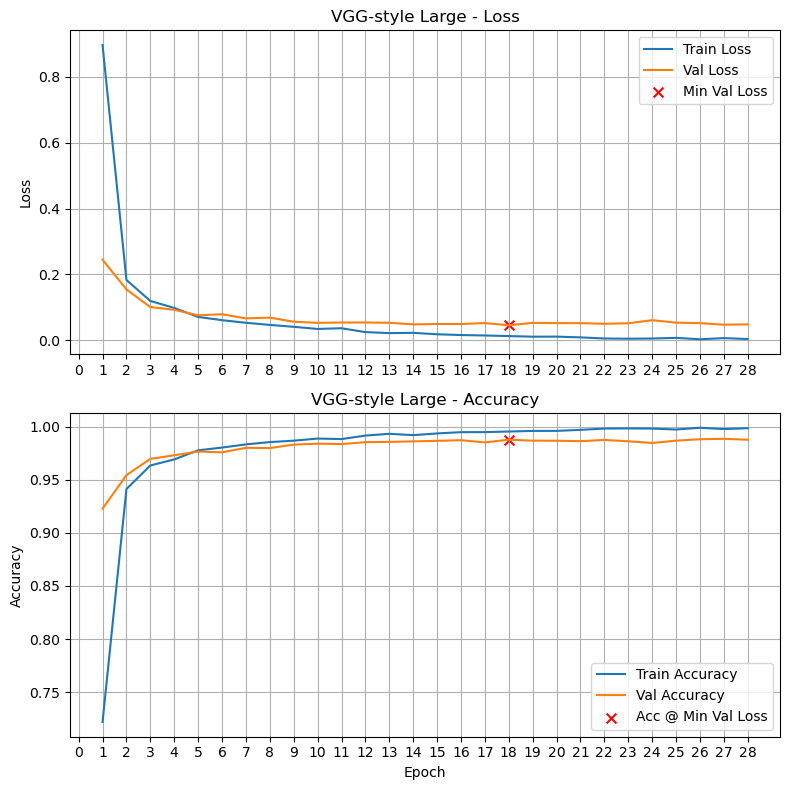

Final Training Loss:            0.0038
Final Training Accuracy:        0.9987
Final Validation Loss:          0.0483
Final Validation Accuracy:      0.9878
Minimum Validation Loss:        0.0457 (Epoch 18)
Validation Accuracy @ Min Loss: 0.9879

Test Accuracy: 0.9889
Test Loss: 0.0399

Validation-Test Gap (accuracy): 0.000983

Execution Time: 00:08:36


In [25]:

model_vgg_16 = models.Sequential([
    Input((28,28,1)),
    # Block 1
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 2
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 3
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 4
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),

    Dense(4096, activation='relu', kernel_initializer='he_normal'),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax'),
])


train_and_test(model_vgg_16,epochs=global_epochs,lr_schedule=0.00001,title="VGG-style Large")


### 8. VGG-16 with Flatten

VGG-style Large with Flatten:  lr_schedule: 1e-05



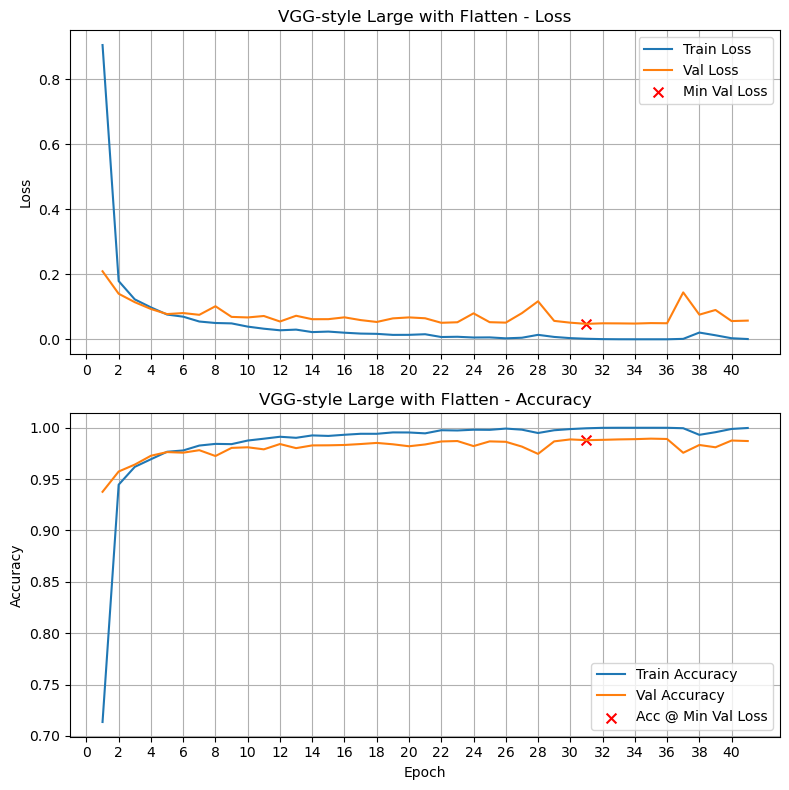

Final Training Loss:            0.0011
Final Training Accuracy:        0.9998
Final Validation Loss:          0.0577
Final Validation Accuracy:      0.9871
Minimum Validation Loss:        0.0477 (Epoch 31)
Validation Accuracy @ Min Loss: 0.9879

Test Accuracy: 0.9898
Test Loss: 0.0359

Validation-Test Gap (accuracy): 0.001883

Execution Time: 00:12:51


In [26]:
model_vgg_16 = models.Sequential([
    Input((28,28,1)),
    # Block 1
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 2
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 3
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 4
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    Flatten(), 

    Dense(4096, activation='relu', kernel_initializer='he_normal'),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax'),
])


train_and_test(model_vgg_16,epochs=global_epochs,lr_schedule=0.00001,title="VGG-style Large with Flatten")

### 9. VGG-16 with Dropout




VGG-style Large with Dropout:  lr_schedule: 1e-05



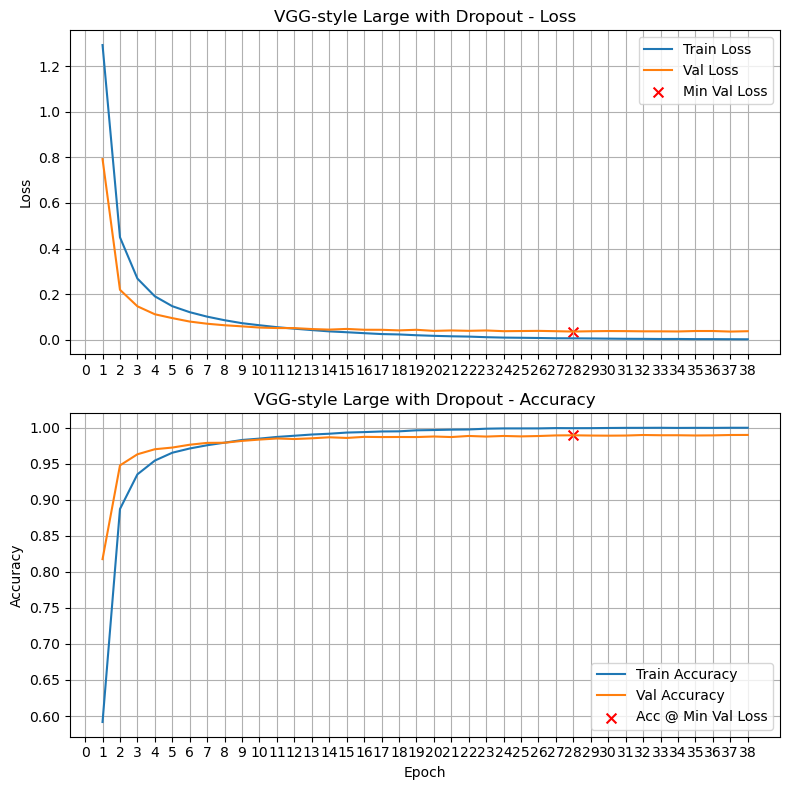

Final Training Loss:            0.0022
Final Training Accuracy:        1.0000
Final Validation Loss:          0.0376
Final Validation Accuracy:      0.9900
Minimum Validation Loss:        0.0361 (Epoch 28)
Validation Accuracy @ Min Loss: 0.9895

Test Accuracy: 0.9910
Test Loss: 0.0282

Validation-Test Gap (accuracy): 0.001500

Execution Time: 00:12:38


In [27]:
model_vgg_16 = models.Sequential([
    Input((28,28,1)),
    # Block 1
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(64,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 2
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(128,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 3
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(256,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    # Block 4
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    Conv2D(512,3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),

    Dense(4096, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1024, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(256, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])


train_and_test(model_vgg_16,epochs=global_epochs,lr_schedule=0.00001,title="VGG-style Large with Dropout")

### 10. Deep CNN

This is from a Medium post:

https://medium.com/@BrendanArtley/mnist-keras-simple-cnn-99-6-731b624aee7f

The author specified a block oriented design with Batch Norm and Dropout
and a head consisting of 3 dense layers 512 -> 1024 -> 10. 

He did not do activation after batch norm, so we changed that to fit current best practices. 

We use the learning rate scheduler from his post. 

Notes:
- Got improvement with exp and cosine decay

Deep CNN:  	callbacks: [<keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler object at 0x4bf15b730>]



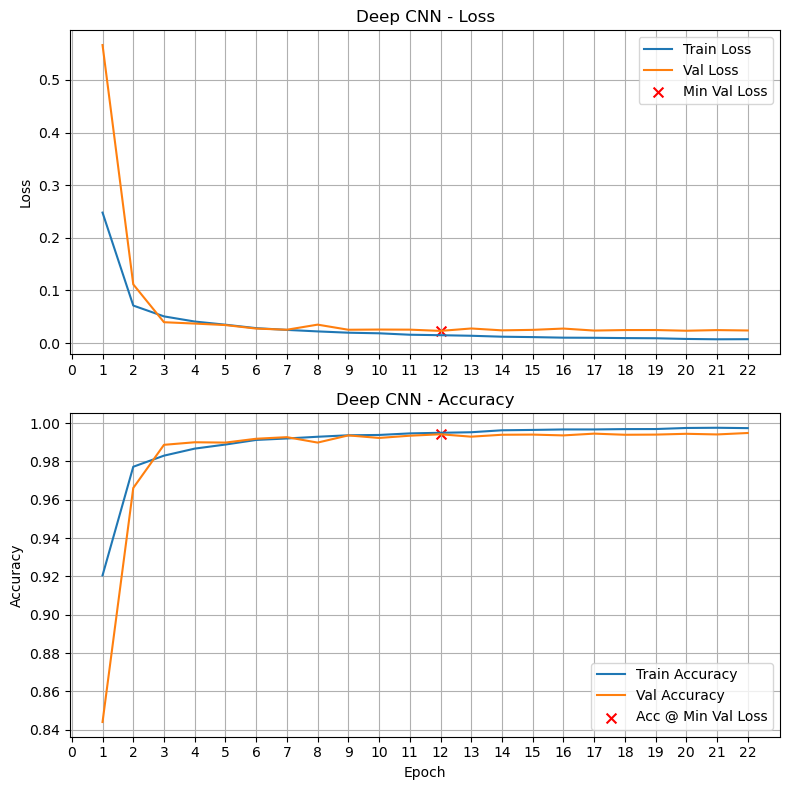

Final Training Loss:            0.0073
Final Training Accuracy:        0.9974
Final Validation Loss:          0.0239
Final Validation Accuracy:      0.9948
Minimum Validation Loss:        0.0231 (Epoch 12)
Validation Accuracy @ Min Loss: 0.9942

Test Accuracy: 0.9945
Test Loss: 0.0165

Validation-Test Gap (accuracy): 0.000333

Execution Time: 00:03:02


In [28]:

model_deep = models.Sequential([
    Input(shape=(28, 28, 1)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(512, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(1024, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')               # default initializer is best for softmax
])

#Define LearningRateScheduler
reduce_lr2 = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

train_and_test(model_deep,
               epochs=global_epochs,
               optimizer = Adam( learning_rate=0.00001, beta_1=0.9, beta_2=0.999 ),
               patience      = 10,                   
               min_delta     = 0.001,
               callbacks=[reduce_lr2],
               title="Deep CNN"
              )



In [ ]:
model_deep_gap = models.Sequential([
    Input(shape=(28, 28, 1)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully connected layers
    GlobalAveragePooling2D(),
    
    Dense(512, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(1024, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')               # default initializer is best for softmax
])

#Define LearningRateScheduler
reduce_lr2 = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

train_and_test(model_deep_gap,
               epochs=global_epochs,
               optimizer = Adam( learning_rate=0.00001, beta_1=0.9, beta_2=0.999 ),
               patience      = 10,                   
               min_delta     = 0.001,
               callbacks=[reduce_lr2],
               title="Deep CNN & GAP"
              )


Deep CNN & GAP:  	callbacks: [<keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler object at 0x525500190>]



### Another Medium Network

This one from:

https://medium.com/data-science/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392

I added `kernel_initializer='he_normal'` and `SpacialDropout2D` in place of `Dropout`. 

After improvements suggested by chatGPT, then added another conv block

THis is the current best model. 

In [ ]:
from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.0005),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.0005),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

        # --- Convolutional Block 3 ---                         # This was added to original design
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.0005),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()
    
    Dense(128, use_bias=False, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



Same but with L2 regularization in all layers. 

Current best model, essentially tied with previous. 

Currently trying chatGPT's advice. 

In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # SpatialDropout2D(0.25),
    Dropout(0.25),

        # --- Convolutional Block 3 ---                         # This was added to original design
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # SpatialDropout2D(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



### 11. Deep Network With Data Augmentation Layer

In [ ]:
# 1) Define your augmentation block without its own InputLayer
data_augmentation = models.Sequential(
    [
        layers.RandomRotation(0.1,         fill_mode="nearest"),  # ±10% of 2π ⇒ ±36°
        layers.RandomZoom(0.1,             fill_mode="nearest"),
        layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
    ],
)



#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    data_augmentation,

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # SpatialDropout2D(0.25),
    Dropout(0.25),

        # --- Convolutional Block 3 ---                         # This was added to original design
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # SpatialDropout2D(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    


    
    # --- Fully Connected Block ---
    # GlobalAveragePooling2D(),                                    # Original used Flatten()
    Flatten(),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    


    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Convolutional Block 2 ---
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()

    Dense(256, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Convolutional Block 2 ---
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(512, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(512, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()

    Dense(1024, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(256, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Convolutional Block 2 ---
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(256, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(256, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()

    Dense(512, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(256, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)


train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



### Best Model

Conv: 32; 64; 128 Dense 128 64 10
L2 Regularization
Spatial Dropout

In [ ]:


#  Same but used L2 in all layers

from tensorflow.keras import models, layers, regularizers

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

conv_l2   = 1e-4
dense_l2  = 7.5e-4

model_deep_3 = models.Sequential([

    # --- Input Layer ---
    Input(shape=(28, 28, 1)),

    # --- Convolutional Block 1 ---
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=5, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),

    # --- Convolutional Block 2 ---
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(64, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    

        # --- Convolutional Block 3 ---                         # This was added to original design
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    Conv2D(128, kernel_size=3, strides=1, padding='same',
           use_bias=False,
           kernel_regularizer=regularizers.l2(conv_l2),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),
    SpatialDropout2D(0.25),
    # Dropout(0.25),
    
    # --- Fully Connected Block ---
    GlobalAveragePooling2D(),                                    # Original used Flatten()
    
    Dense(128, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(64, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(dense_l2)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # --- Output Layer ---
    Dense(10, activation='softmax')
])

variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=0
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)
global_epochs = 300

train_and_test(
    model_deep_3,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.00001,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 0
)



Initial LR: 0.

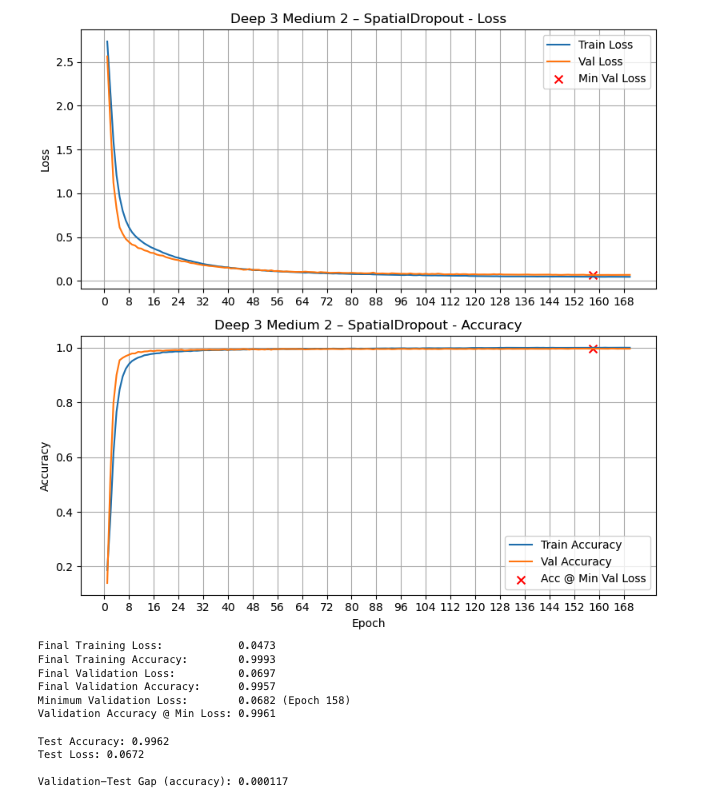

In [ ]:
from tensorflow.keras import models, layers, regularizers

# ----- Hyper‑parameters -------------------------------------------------
conv_l2   = 1e-4
dense_l2  = 7.5e-4

# ----- Residual block helper -------------------------------------------
def residual_block(x, filters, k=3, down=False, name=None):
    """
    Basic two‑conv residual block (v1 style).
    If `down=True` the first conv uses stride 2, so the block halves H,W.
    If input channels ≠ filters, the shortcut is projected with 1×1 conv.
    """
    stride = 2 if down else 1
    shortcut = x

    # ----- conv‑BN‑ReLU 1 -----
    x = layers.Conv2D(filters, k, padding="same", strides=stride,
                      use_bias=False,
                      kernel_regularizer=regularizers.l2(conv_l2),
                      kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # ----- conv‑BN 2 -----
    x = layers.Conv2D(filters, k, padding="same", strides=1,
                      use_bias=False,
                      kernel_regularizer=regularizers.l2(conv_l2),
                      kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    # ----- shortcut -----
    if down or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding="same", strides=stride,
                                 use_bias=False,
                                 kernel_regularizer=regularizers.l2(conv_l2),
                                 kernel_initializer="he_normal")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # ----- merge -----
    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

# ----- Model definition -------------------------------------------------
inputs = layers.Input(shape=(28, 28, 1))

# Block 1: 32 filters, keep resolution, then pool by stride=2 via residual
x = residual_block(inputs, 32, k=5, down=False)   # 28×28×32
x = layers.SpatialDropout2D(0.25)(x)
x = residual_block(x, 32, k=5, down=True)         # 14×14×32

# Block 2: 64 filters
x = residual_block(x, 64, k=3, down=False)        # 14×14×64
x = layers.SpatialDropout2D(0.25)(x)
x = residual_block(x, 64, k=3, down=True)         # 7×7×64

# Block 3: 128 filters
x = residual_block(x, 128, k=3, down=False)       # 7×7×128
x = layers.SpatialDropout2D(0.25)(x)
x = residual_block(x, 128, k=3, down=True)        # 3×3×128

# Global pooling and dense head
x = layers.GlobalAveragePooling2D()(x)            # 128 features
x = layers.Dense(128, use_bias=False,
                 kernel_initializer="he_normal",
                 kernel_regularizer=regularizers.l2(dense_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(64, use_bias=False,
                 kernel_initializer="he_normal",
                 kernel_regularizer=regularizers.l2(dense_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model_resnet = models.Model(inputs, outputs, name="MNIST_ResNet_like")


variable_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # cut LR in half
    patience=7,       # wait 5 epochs with no improvement
    min_delta=1e-4,   # must beat val_loss by at least 0.001
    min_lr=1e-8,
    verbose=1
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4)
global_epochs = 300

train_and_test(
    model_resnet,                 # <- note the correct model name
    epochs=global_epochs,
    # optimizer = optimizer,
    lr_schedule=0.0005,             # let the callback handle LR
    use_early_stopping = True,
   patience      = 12,                     # To turn off early stopping, set patience to same as epochs
   min_delta     = 0.0001,
    callbacks=[variable_learning_rate],
    batch_size=256,               # smoother gradients
    title="Deep 3 Medium 2 – SpatialDropout",
    verbose= 1
)

In [ ]:
notebook_end = time.time()
print(f"Notebook Execution Time: " + format_hms(notebook_end-notebook_start))

In [ ]:
# Print results sorted by accuracy (highest → lowest)

for title, (acc, ep) in sorted(results.items(), 
                               key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                               reverse=True):
    print(f"{title:<40}\t{acc:.4f} @ {ep}")

## Appendix One:  Some "Rules of Thumb" for CNNs

### Architecture & Ordering

1. **Use Blocks of Conv → BatchNorm → ReLU**
   Normalize first, then add non-linearity for stabler gradients.
2. **Small filters, deep network**
   Stacks of 3 × 3 give the same receptive field as one 7 × 7 but with fewer weights.
3. **Halve size, double channels**
   When you down-sample (stride 2 or max-pool), bump filters 2× to keep capacity.
4. **GlobalAvgPool beats huge Dense blocks**
   Replaces tens of thousands of weights with a single spatial average.

### Regularization & Initialization

5. **Dropout after Dense (or SpatialDropout after Conv)**
   Standard dropout ignores spatial structure; use it where it hurts least.
6. **He init for ReLU, Glorot for tanh**
   Pick an initializer that matches your activation to avoid vanishing/exploding activations.
7. **Weight decay ≈ 1e-4 by default**
   A little ℓ2 keeps weights from drifting without heavy hyper-tuning.

### Data & Training

8. **Normalize inputs early, augment on the fly**
   Centering/scaling once; flip/crop/shift every epoch for fresh variety.
9. **Learning-rate schedule > optimizer tweaks**
   A good decay (exponential, cosine, OneCycle) usually beats exotic optimizers.
10. **Batch size: fit the GPU, don’t chase myths**
    Use the largest batch that fits memory; tune LR if you change it.

### Monitoring & Debugging

11. **Watch train vs. val curves, not just accuracy**
    Divergence signals overfitting; flat lines signal undercapacity or bad LR.
12. **First sanity check: overfit a tiny subset**
    If the model can’t hit 100 % on 10 images, something else is broken.



## Appendix Two: Data Augmentation


One of the most powerful tools in your toolbox for image processing is Data Augmentation—the process of creating additional training samples by changing various characteristics of the image that do not change its essential character:

- Geometry: rotation, flipping horizontally or vertically, zooming, shifting;
- Photometrics: Brightness, contrast, blur, saturation and hue shifts;
- Cropping and Rescaling: select certain parts of the image or change range of pixel values.

Other, more sophisticated approaches include overlaying one image over another, or moving objects localized in one image into another image. 


Data augmentation is a powerful tool to improve the performance of CNNs by synthetically increasing the diversity of your training dataset—without collecting new data. By training the model to handle real-world noise and variability, it helps models generalize better and reduces the risk of overfitting.


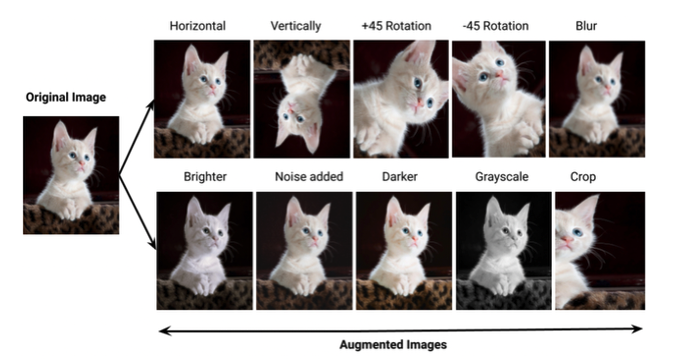


Data Augmentation can be performed “on the fly” by adding layers to the network, or by explicitly adding new samples to your dataset. The first approach is generally only usable when relatively simple transformations are applied. Keras supports the following layer transformations:

- RandomFlip (horizontal or vertical), 
- RandomRotation, 
- RandomZoom, 
- RandomTranslation, 
- RandomContrast, and 
- RandomBrightness. 

These layers apply randomized but label-preserving transformations directly to the input images during training—without modifying the original dataset—making them ideal for real-time augmentation with minimal memory overhead.

When is Augmentation not Appropriate?

- Use it during training only—not on validation/test sets.
- Avoid excessive augmentation that alters the semantic content (e.g., flipping text or distorting faces unnaturally).
- Use domain-specific logic:
    - Don’t flip chest X-rays (left/right symmetry matters).
    - Random cropping may not be suitable for small objects.
When used appropriately, data augmentation is one of your best tools for effective training of neural networks for image processing tasks. 


#### Viewing the Data Augmentations for MNIST

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1) Build your augmentation pipeline with an explicit InputLayer
data_augmentation = models.Sequential([
    InputLayer(input_shape=(28,28,1)),
    RandomRotation(0.1,    fill_mode="nearest"),  # up to ±36°
    RandomZoom(0.1,        fill_mode="nearest"),
    RandomTranslation(0.1, 0.1, fill_mode="nearest"),
    RandomContrast(0.1),
], name="data_augmentation")

# 2) Grab one example and cast to float32
#    (this assumes x_train in [0,1]; if yours is 0–255, divide by 255.0 first)
single_image = X_train[0]                     # shape (28,28,1) or (28,28)
single_image = np.expand_dims(single_image, -1) if single_image.ndim==2 else single_image
single_image = single_image.astype("float32")
label = np.argmax(y_train[0])

# 3) Make a batch of N copies in one go
N = 8
batch = tf.repeat(single_image[None,...], repeats=N, axis=0)  # shape (N,28,28,1)

# 4) Augment + clip
augmented_batch = data_augmentation(batch, training=True)
augmented_batch = tf.clip_by_value(augmented_batch, 0.0, 1.0)

# 5) Plot 3×3 grid: original + 8 variants
plt.figure(figsize=(10,10))

# original in top-left
plt.subplot(3,3,1)
plt.imshow(single_image[...,0], cmap="gray")
plt.title(f"Original: {label}")
plt.axis("off")

# then the augmented ones
for i in range(N):
    plt.subplot(3,3,i+2)
    plt.imshow(augmented_batch[i,...,0].numpy(), cmap="gray")
    plt.axis("off")

plt.suptitle("MNIST: Original + 8 Augmented Variants")
plt.tight_layout()
plt.show()


### Appendix Three: Using TensorBoard


TensorBoard is an interactive visualization tool which logs training progress and lets you inspect loss, accuracy, learning rate, and many other statistics over time. 

If you are only interested in loss and accuracy, this is a bit of overkill, but definitely worth checking out. 

You set it up using a callback, as we described in last week's coding notebook. 


In [ ]:
'''
# Define log directory (unique per run)
log_dir = os.path.join("logs", "fit", time.strftime("run_%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Optional: add EarlyStopping or others if desired
callbacks_list = [tensorboard_cb]

# Start timing
start = time.time()

# Training parameters
n_epochs = 100
batch_size = 128

# Build and train the model
base_model = build_model(lr=1e-4)
history_base = base_model.fit(
    X_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=callbacks_list,
    verbose=0
)

# End timing
end = time.time()
print(f"\nTotal Execution Time: {format_time(end-start)}")
'''
None


Once you've run this, you can visualize the training progress by running the following command in your terminal (from the root of your project):

```bash
tensorboard --logdir=logs/fit
```

Then open your browser and go to [http://localhost:6006](http://localhost:6006).

